<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/04-recurrent-neural-networks/02_simple_sequence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple sequence classification

Let’s start by creating a many-to-one classification problem. 

What do I mean by this?

We will have many inputs (every time step), but we will have only one output: the class label we are trying to predict.

For a simple sequence classification problem, we will take an example of identifying the language a name comes from.

For example, “Steven” is an English name.
Note that this problem can’t be solved perfectly—for example, “Frank” could be English
or German—so we should expect some errors due to these issues and oversimplification.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/04-recurrent-neural-networks/images/2.png?raw=1' width='600'/>

RNN process for classifying a name’s source language. The individual characters of a name
make the sequence that is fed into the RNN. 

We learn how to convert each character into a vector and
how to get an RNN to process that sequence and return a final activation $h_T$ , and we end with a linear
layer that produces a prediction.



##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import requests, zipfile, io
import unicodedata
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

from scipy.signal import convolve

import time

from idlmam import train_simple_network, set_seed, Flatten, weight_reset

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's downloads the dataset and extracts all the files.

In [5]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

# Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language
req = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(req.content))
z.extractall()

##Preparing dataset

Since this dataset is pretty small, we load all of it into memory.

In [6]:
# dictionary, which maps the language name
namge_language_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}

for i in range(n_letters):
  alphabet[all_letters[i]] = i

In [7]:
def unicode_to_ascii(s):
  return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn" and c in all_letters)

In [8]:
# Loops through every language, opens the zip file entry, and reads all the lines from the text file
for zip_path in z.namelist():
  if "data/names/" in zip_path and zip_path.endswith(".txt"):
    lang = zip_path[len("data/names/"): -len(".txt")]
    with z.open(zip_path) as zipfile:
      # Turns a Unicode string into plain ASCII
      lang_names = [unicode_to_ascii(line).lower() for line in str(zipfile.read(), encoding="utf-8").strip().split("\n")]
      namge_language_data[lang] = lang_names
    print(f"{lang}: {str(len(lang_names))}")

Arabic: 2000
Chinese: 268
Czech: 519
Dutch: 297
English: 3668
French: 277
German: 724
Greek: 203
Irish: 232
Italian: 709
Japanese: 991
Korean: 94
Polish: 139
Portuguese: 74
Russian: 9408
Scottish: 100
Spanish: 298
Vietnamese: 73


Now we have created a dataset, which you may notice is not well balanced: there are far
more Russian names than any other language.

With our data loaded in memory, we can now implement a Dataset to represent it.

In [9]:
class LanguageNameDataset(Dataset):

  def __init__(self, lang_name_dict, vocabulary) -> None:
    self.label_names = [x for x in lang_name_dict.keys()]
    self.data = []
    self.labels = []
    self.vocabulary = vocabulary
    for y, language in enumerate(self.label_names):
      for sample in lang_name_dict[language]:
        self.data.append(sample)
        self.labels.append(y)

  def __len__(self):
    return len(self.data)

  def string2vec(self, input_string):
    """
    This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
    input_string: the string to convert to a tensor
    """
    # How many characters long is the string?
    T = len(input_string)
    # Create a new tensor to store the result in
    name_vec = torch.zeros((T), dtype=torch.long)
    # iterate through the string and place the appropriate values into the tensor
    for pos, character in enumerate(input_string):
      name_vec[pos] = self.vocabulary[character]
    return name_vec

  def __getitem__(self, index):
    name = self.data[index]
    label = self.labels[index]
    # Conver the correct class label into a tensor for PyTorch
    label_vec = torch.tensor([label], dtype=torch.long)
    return self.string2vec(name), label

Let's creates a train/test split, with 300 items in the test split.

In [10]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset) - 300, 300))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

##Embedding layers

Embedding layers are lookup tables designed to map each integer value to a specific
vector representation. You tell the embedding layer how large the vocabulary is (i.e.,
how many unique items exist) and how large you want the output dimension to be.

The last thing we need is a way to map each integer to a corresponding vector, which is accomplished using an embedding layer.

In [11]:
with torch.no_grad():
  input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
  embedding = nn.Embedding(3, 2)
  x_seq = embedding(input_sequence)
  print(input_sequence.shape, x_seq.shape)
  print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[-1.0839,  2.1440],
        [ 0.6532,  0.7195],
        [ 0.6532,  0.7195],
        [-1.0839,  2.1440],
        [ 1.0832,  1.1107]])


Note that the first and fourth rows of the matrix have the same values, as do the second and third. 

This is because the order
in the output matches the order in the input.

##RNN algorithm

The last time step is the only one that carries information from all $T$ inputs based on the input’s order. This way, we can use $h_T$ as a fixed-length summary of the input data for a fully connected sub-network. This works because $h_T$ has the same shape and size no matter how long
the input sequence is.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/04-recurrent-neural-networks/images/3.png?raw=1' width='600'/>

In [12]:
class LastTimeStep(nn.Module):
  """
  A class for extracting the hidden activations of the last time step following the output of a PyTorch RNN module.
  """
  def __init__(self, rnn_layers=1, bidirectional=False):
    super(LastTimeStep, self).__init__()
    self.rnn_layers = rnn_layers 
    if bidirectional:
      self.num_driections =2
    else:
      self.num_driections = 1

  def forward(self, input):
    # Result is either a tupe (out, h_t) or a tuple (out, (h_t, c_t))
    rnn_output = input[0]
    last_step = input[1] # this will be h_t

    # unless it's a tuple then h_t is the first item in the tuple
    if (type(last_step) == tuple):
      last_step = last_step[0]
    batch_size = last_step.shape[1]   # shape is: '(num_layers * num_directions, batch, hidden_size)'
    # reshaping so that everything is separate
    last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
    # We want the last layer's results
    last_step = last_step[self.rnn_layers - 1]
    # Re-order so batch comes first
    last_step = last_step.permute(1, 0, 2)
    # Finally, flatten the last two dimensions into one
    return last_step.reshape(batch_size, -1)

The output of a RNN in PyTorch is a tuple of shape $(out,h_T )$ or $(out, (h_T, c_T))$. 

The out object has information about every time step, and $h_T$ contains information about only the last time step but for every layer.

In [13]:
D = 64

vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D),                # (B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True),  # (B, T, D) -> ((B,T,D) , (S, B, D))
  # We need to take the RNN output and reduce it to one item, (B, D)
  LastTimeStep(),
  nn.Linear(hidden_nodes, classes)            # (B, D) -> (B, classes)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn,
                                       loss_func,
                                       train_loader,
                                       test_loader=test_loader,
                                       score_funcs={"Accuracy": accuracy_score},
                                       device=device,
                                       epochs=5)

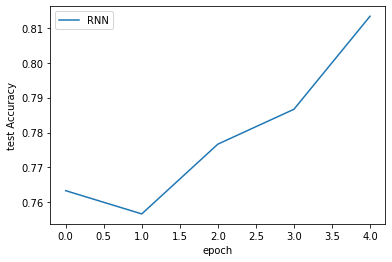

In [15]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

Let’s try typing in a
few names and see what the model thinks of them.

In [17]:
pred_rnn = first_rnn.to("cpu").eval()

with torch.no_grad():
  preds = F.softmax(pred_rnn(dataset.string2vec("frank").reshape(1, -1)), dim=-1)
  for class_id in range(len(dataset.label_names)):
    print(dataset.label_names[class_id], ":", preds[0, class_id].item() * 100, "%")

Arabic : 0.001122212597692851 %
Chinese : 0.0862760643940419 %
Czech : 22.20924347639084 %
Dutch : 4.248766601085663 %
English : 50.13500452041626 %
French : 0.5417836830019951 %
German : 15.045268833637238 %
Greek : 0.018246257968712598 %
Irish : 1.0694915428757668 %
Italian : 1.0196181014180183 %
Japanese : 0.005653195330523886 %
Korean : 0.37979918997734785 %
Polish : 2.0000992342829704 %
Portuguese : 0.12433277443051338 %
Russian : 1.0086477734148502 %
Scottish : 1.7019633203744888 %
Spanish : 0.16876028385013342 %
Vietnamese : 0.23592899087816477 %


In [19]:
with torch.no_grad():
  preds = F.softmax(pred_rnn(dataset.string2vec("John").reshape(1, -1)), dim=-1)
  for class_id in range(len(dataset.label_names)):
    print(dataset.label_names[class_id], ":", preds[0, class_id].item() * 100, "%")

Arabic : 3.4034594893455505 %
Chinese : 22.673167288303375 %
Czech : 0.10270748753100634 %
Dutch : 0.7496355101466179 %
English : 17.586320638656616 %
French : 0.9634407237172127 %
German : 6.102918833494186 %
Greek : 0.038853680598549545 %
Irish : 23.45985323190689 %
Italian : 0.2554016653448343 %
Japanese : 0.28490894474089146 %
Korean : 14.22324925661087 %
Polish : 0.019630407041404396 %
Portuguese : 0.11705971555784345 %
Russian : 0.5558361764997244 %
Scottish : 2.2301634773612022 %
Spanish : 0.13029727851971984 %
Vietnamese : 7.103089243173599 %
